# Machine Learning Homework 6 —— k-means clustering, kernel k-means, spectral clustering, DBSCAN
##### 0756021 張逸群

### Homework Objective
* Use whatever your favorite language to code out k- means clustering, kernel k-means, spectral clustering and DBSCAN.
* You are allowed to use `NumPy` and it can help you to solve the eigenvalue problem. 
* Using the `matplotlib` is legal. But you **can’t** use `scikit-learn` and `SciPy` in this homework.
* (kernel k-means and spectral clustering both based on RBF kernels)
    
### Dataset
* 2 datasets with points on 2d space - circle.txt, moon.txt

##### This report contains both source codes and results.
##### Please also check the gifs provided in the `gifs` folder, to examine the clustering process of each clustering algorithm. 

In [1]:
import numpy as np
from IPython.display import Image, display
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

np.random.seed(42)

%matplotlib inline

## Read data

In [2]:
def read_data(filename):
    points = list()
    with open(filename, 'r') as f:
        for line in f:
            Xi, yi = map(float, line.split(','))
            points.append([Xi, yi])
    return np.array(points)

In [3]:
circle = read_data('./circle.txt')
moon = read_data('./moon.txt')

### Visualization

Text(0.5, 1.0, 'moon.txt')

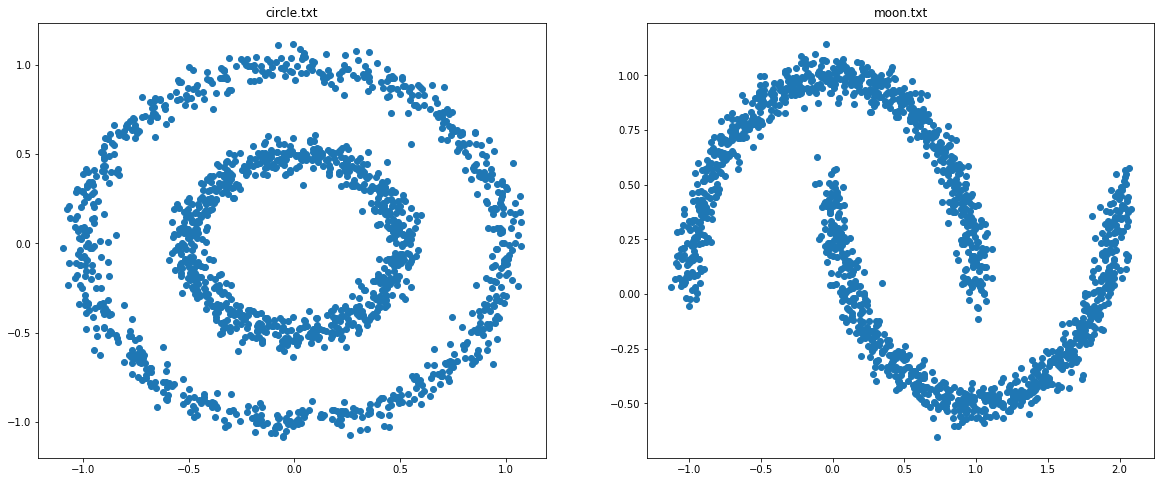

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 8))
ax1.scatter(circle[:, 0], circle[:, 1])
ax1.set_title('circle.txt')

ax2.scatter(moon[:, 0], moon[:, 1])
ax2.set_title('moon.txt')

## GIF Generator

I choose to utilize `matplotlib.animation.FuncAnimation` to generate gifs.  
The following code segment is basically taken from [StackOverflow](https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot).
First I collect clustering labels and centers of every step and generate a scatter chart for each step to construct a gif.

In [5]:
# basically from https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
class GIFGenerator():
    def __init__(self, points, title_prefix='', color_fix=False):
        self.points = points
        self.title_prefix = title_prefix
        self.group_centors = list()
        self.group_indices = list()
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        self.color_fix=True
    
    def add_frame(self, group_centors=None, group_indices=None):
        if group_centors is not None:
            self.group_centors.append(group_centors)
            
        self.group_indices.append(group_indices)
        return
        
    def setup_plot(self):
        self.point_scat = self.ax.scatter(self.points[:, 0], self.points[:, 1], c=self.group_indices[0])
        self.ax.set_title('{} iteration-0'.format(self.title_prefix))
        
        if self.color_fix:
            self.ax.annotate('add two points to fix color, don\'t mind me', xy=(-1, 1), xytext=(-1.1, 1.1))
        
        if len(self.group_centors) > 0:
            self.centor_scat = self.ax.scatter(self.group_centors[0][:, 0], self.group_centors[0][:, 1], color='red', s=50, marker='^')
            return self.point_scat, self.centor_scat
        
        return self.point_scat, 
        
    def update(self, i):
        self.point_scat.set_array(self.group_indices[i])
        self.ax.set_title('{} iteration-{}'.format(self.title_prefix, i))
        
        if len(self.group_centors) > 0:
            self.centor_scat.set_offsets(self.group_centors[i])
            return self.point_scat, self.centor_scat
        
        return self.point_scat, 
        
    def close(self):
        plt.close(self.fig)
        
    def save(self, filename, interval=500, display=False):
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=interval, frames=list(range(len(self.group_indices))),
                                          init_func=self.setup_plot, blit=False, repeat=True)
        self.ani.save(filename, writer='imagemagick')
        plt.close(self.fig)
        if display: display(Image(filename=filename))

In [6]:
def plot_result(ax, points, group_centors, group_indices, title):
    ax.scatter(points[:, 0], points[:, 1], c=group_indices)
    if group_centors is not None:
        ax.scatter(group_centors[:, 0], group_centors[:, 1], color='red', s=50, marker='^')
    ax.set_title(title)

## K-means Clustering

Lloyd's Algorithm is chosen for K-means clustering. As mentioned in class, K-means is essentially a simplified EM algorithm.
* Initialization
	* Random Init
		* Randomly assign each point to a group and calculate the corresponded center using the mean of each dimension
	* K-means++
		* Randomly choose a point from data for the center of the first group
		* Calculate the distances between each data point and the last chosen center, and use it as a probability to choose next center point
		* Repeat the last step until `ngroup` groups' centers are determined
* E step
	* Assign each data point to the group with the nearest center
* M step
	* Recalculate the center of each group
* Repeat E and M step until the centers of every group don't move

However, it might cause some problems if no point is assigned to a certain group during some certain point in time. In order to deal with it, a check procedure is performed at the end of each EM iteration to ensure every group has some points in it or the K-means function will start over from the initialization.

In [7]:
def lloyd_kmeans(points, ngroups, kmeans_plus=False, title_prefix='', gif_filename='lloyd_kmeans.gif', gif_points_overwrite=None, verbose=True):
    def random_centor_init(points):
        # random init centors
        random_indices = np.random.choice(np.arange(0, points.shape[0], 1, dtype=int), size=points.shape[0], replace=False)
        random_groups = np.split(points[random_indices], ngroups)
        return np.array([g.mean(axis=0) for g in random_groups])

    def kmeans_plus_centor_init(points):
        centors = [points[np.random.randint(points.shape[0])]]
        for i in range(ngroups - 1):
            # calculate the distance between a point to it's nearest centor
            distances = np.zeros((points.shape[0], i+1))
            for gi in range(i+1):
                distances[:, gi] = np.power(points - centors[gi], 2).sum(axis=1)
            distances = np.min(distances, axis=1)
            probability = distances / distances.sum()
            
            index_next_centor = np.random.choice(np.arange(0, points.shape[0], 1, dtype=int), p=probability)
            centors.append(points[index_next_centor])
        return np.array(centors)
    
    def calculate_centors(points, group_indices):
        return np.array([points[np.where(group_indices == gi)[0]].mean(axis=0) for gi in range(ngroups)])
    
    def has_empty_group(group_indices):
        for gi in range(ngroups):
            if np.where(group_indices == gi)[0].shape[0] == 0:
                return True
        return False

    def split_by_centors(points, centors):
        distances = np.zeros((points.shape[0], ngroups))
        for gi in range(ngroups):
            distances[:, gi] = np.power(points - centors[gi], 2).sum(axis=1)
        group_indcies = np.argmin(distances, axis=1)
        return group_indcies
    
    if verbose:
        if gif_points_overwrite is not None:
            gif_generator = GIFGenerator(gif_points_overwrite, title_prefix)
        else:
            gif_generator = GIFGenerator(points, title_prefix)
        
    
    if kmeans_plus:
        group_centors = kmeans_plus_centor_init(points)
    else:
        group_centors = random_centor_init(points)
    while True:
        group_indices = split_by_centors(points, group_centors)
        
        if verbose: 
            if gif_points_overwrite is not None:
                gif_generator.add_frame(group_indices=group_indices)
            else:
                gif_generator.add_frame(group_centors, group_indices)
                
        new_group_centors = calculate_centors(points, group_indices)
        if (group_centors == new_group_centors).any():
            break
            
        # check empty group
        if has_empty_group(group_indices):
            print('empty group found! retry!')
            gif_generator.close()
            return lloyd_kmeans(points, ngroups, kmeans_plus, title_prefix, gif_filename, gif_points_overwrite, verbose)
            
        group_centors = new_group_centors
    
    if verbose: gif_generator.save(gif_filename)
        
    return group_centors, group_indices

The following sections are the results of different settings.  
Due to the characteristic of K-means:
* the separations between groups are all straight lines
* Each group has roughly the same number of points

And according to the gifs, I believe the clustering process using K-mean++ is more robust due to the better initial choice of center points. However, K-means++ initialization doesn't change the clustering result much.

### Circle - Random Init - 2, 3, 4 groups

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


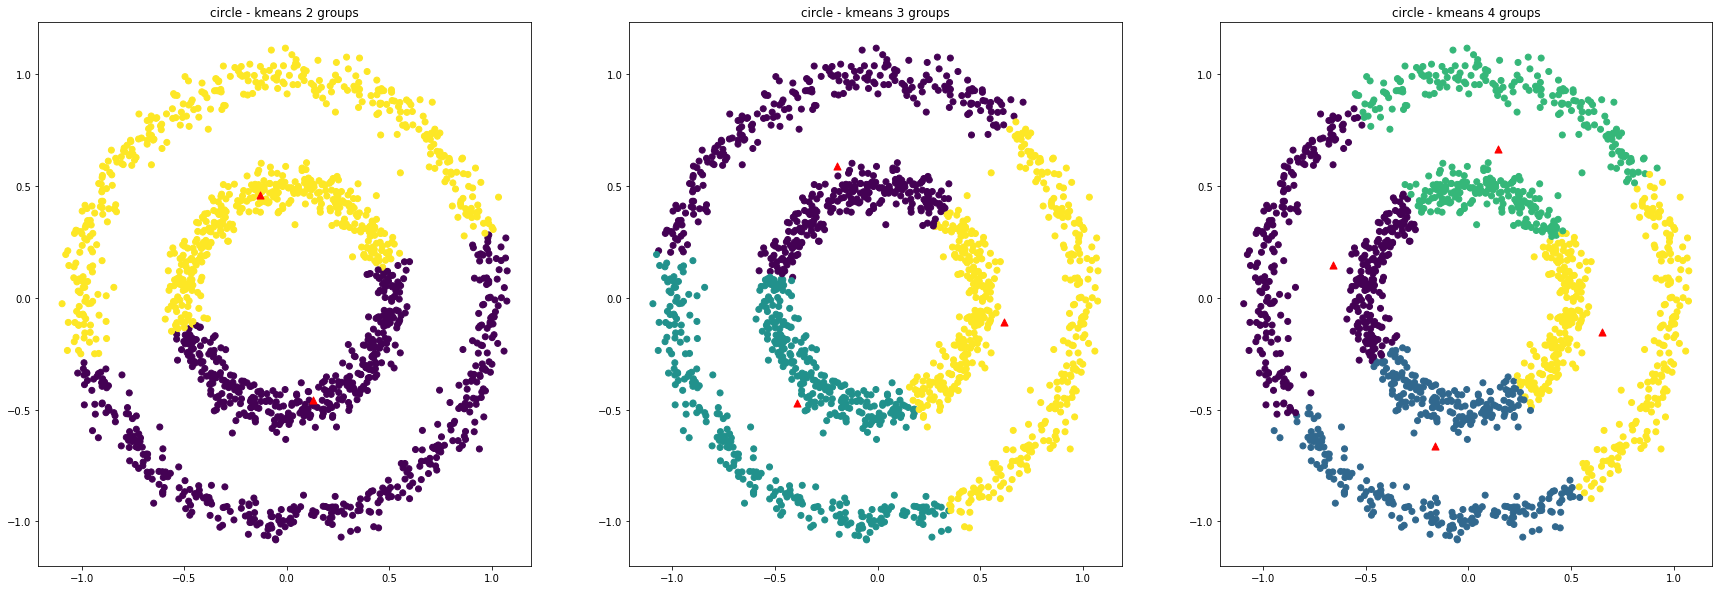

In [8]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(30, 10))

for i, ax in enumerate(axes):
    ngroups = i + 2
    group_centors, group_indices = lloyd_kmeans(circle, ngroups, False, 'circle - kmeans {} groups'.format(ngroups), 'circle_lloyd_kmeans_{}groups.gif'.format(ngroups))
    plot_result(ax, circle, group_centors, group_indices, 'circle - kmeans {} groups'.format(ngroups))

plt.show()

### Circle - K-means++ - 2, 3, 4 groups

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


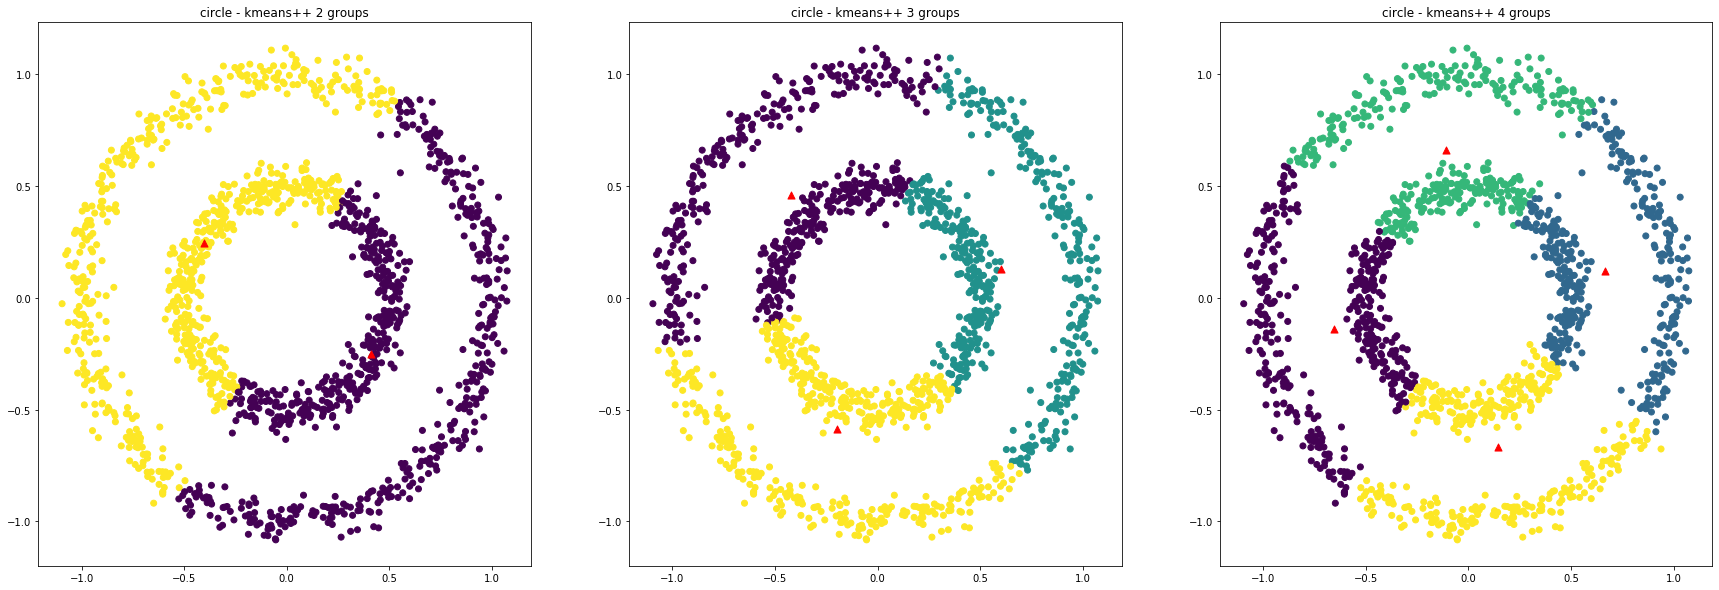

In [9]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(30, 10))

for i, ax in enumerate(axes):
    ngroups = i + 2
    group_centors, group_indices = lloyd_kmeans(circle, ngroups, True, 'circle - kmeans++ {} groups'.format(ngroups), 'circle_lloyd_kmeans++_{}groups.gif'.format(ngroups))
    plot_result(ax, circle, group_centors, group_indices, 'circle - kmeans++ {} groups'.format(ngroups))

plt.show()

### Moon - Random Init - 2, 3, 4 groups

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


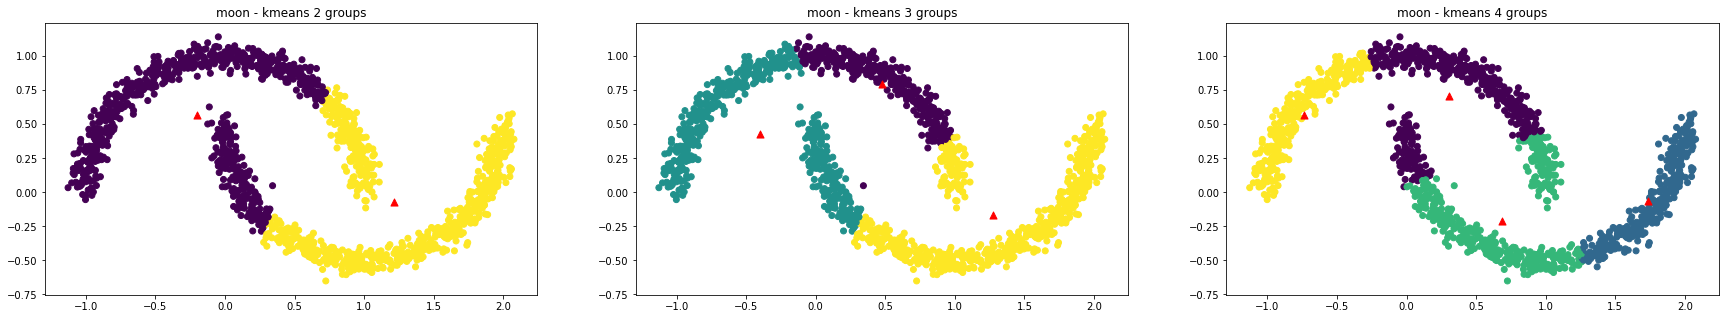

In [10]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(30, 5))

for i, ax in enumerate(axes):
    ngroups = i + 2
    group_centors, group_indices = lloyd_kmeans(moon, ngroups, False, 'moon - kmeans {} groups'.format(ngroups), 'moon_lloyd_kmeans_{}groups.gif'.format(ngroups))
    plot_result(ax, moon, group_centors, group_indices, 'moon - kmeans {} groups'.format(ngroups))

plt.show()

### Moon - K-means++ - 2, 3, 4 groups

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


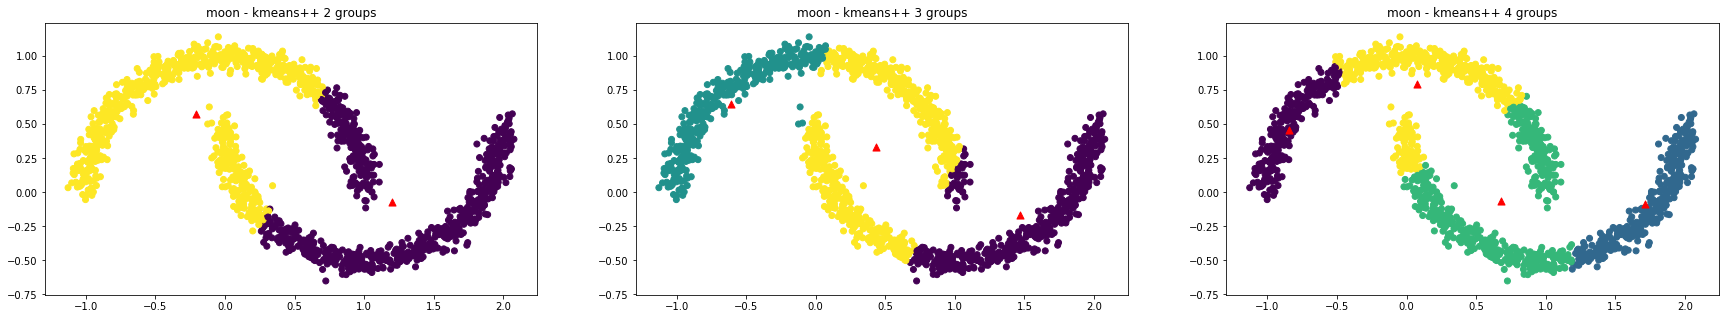

In [11]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(30, 5))

for i, ax in enumerate(axes):
    ngroups = i + 2
    group_centors, group_indices = lloyd_kmeans(moon, ngroups, True, 'moon - kmeans++ {} groups'.format(ngroups), 'moon_lloyd_kmeans++_{}groups.gif'.format(ngroups))
    plot_result(ax, moon, group_centors, group_indices, 'moon - kmeans++ {} groups'.format(ngroups))

plt.show()

## Kernel K-means Clustering

The biggest difference between K-means and kernel K-means is the way they define distance.  
In K-means, Euclidian distance is used while arbitrary kernel function can be used in kernel K-means to quantized distance.  
Yet, after replacing the way of measuring distance, using Euclidian mean as centers is no longer feasible.  
So the whole process of center computing is skipped and is merged into the group assigning step. As a result, every iteration only contains one step, updating the labels of data points (`alpha`).  

The group assigning process is done by the following steps:
1. Calculating the distance between each point to the existing groups by the formula below
![kernel_k_means](https://imgur.com/JjRmY4Z.jpg)
2. Assign each point to its' nearest group (has the minimum distance) and update clustering groups

The RBF kernel is chosen as it's specified in the homework specs. The corresponding Python code utilizes the fact, ```||x-y||^2 = ||x||^2 + ||y||^2 - 2 * x^T * y```, to make it easier to implement. The kernel function uses two variables, `var` and `gamma`, which need to be set beforehand. 

In [12]:
def kernel_kmeans(points, ngroups, gamma, var, title_prefix='', gif_filename='kernel_kmeans.gif'):
    def rbf_distance_matrix(X, gamma=gamma, var=var):
        # base on https://stackoverflow.com/questions/47271662/what-is-the-fastest-way-to-compute-an-rbf-kernel-in-python
        X_norm = np.sum(X ** 2, axis = -1)
        K = var * np.exp(-gamma * (X_norm[:,None] + X_norm[None,:] - 2 * np.dot(X, X.T)))
        return K
    
    def group_indices_to_alpha(group_indices):
        alpha = np.zeros((points.shape[0], ngroups))
        for gi in range(ngroups):
            alpha[:, gi] = (group_indices == gi)
        return alpha
    
    def alpha_to_group_indices(alpha):
        return np.argmax(alpha, axis=1)
    
    def random_alpha_init(points):
        group_indices = np.random.randint(ngroups, size=points.shape[0])
        return group_indices_to_alpha(group_indices)
    
    def calculate_alpha(distance_matrix, alpha):
        distances = np.zeros((points.shape[0], ngroups))
        for gi in range(ngroups):
            alpha_k = alpha[:, gi]
            ck_size = alpha_k.sum()
            distances[:, gi] = np.diagonal(distance_matrix)
            distances[:, gi] -= 2 / ck_size * np.apply_along_axis(lambda dmj: (alpha_k * dmj).sum(), 0, distance_matrix)
            distances[:, gi] += 1 / (ck_size*ck_size) * ((alpha_k[..., np.newaxis] @ alpha_k[np.newaxis, ...]).T * distance_matrix).sum()
            
        group_indices = np.argmin(distances, axis=1)
        return group_indices_to_alpha(group_indices)
    
    gif_generator = GIFGenerator(points, title_prefix)
    
    distance_matrix = rbf_distance_matrix(points)
    alpha = random_alpha_init(points)
        
    while True:
        gif_generator.add_frame(group_indices=alpha_to_group_indices(alpha))
        
        new_alpha = calculate_alpha(distance_matrix, alpha)
        if (alpha == new_alpha).all():
            break
            
        alpha = new_alpha
        
    gif_generator.save(gif_filename)
    return alpha_to_group_indices(alpha)

The results are shown below.  
Since I believe K-means++'s initialization method doesn't apply on feature space, only the random initialization method is implemented.
Through the results of kernel K-means is better than traditional K-means,  kernel K-means still can't separate the inner circle from the outer one.  
Also, it's harder for it to be interpreted due to the fact that it elevates the data points to a much more complicated feature space.


### Circle - Random Init - 2, 3, 4 groups

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


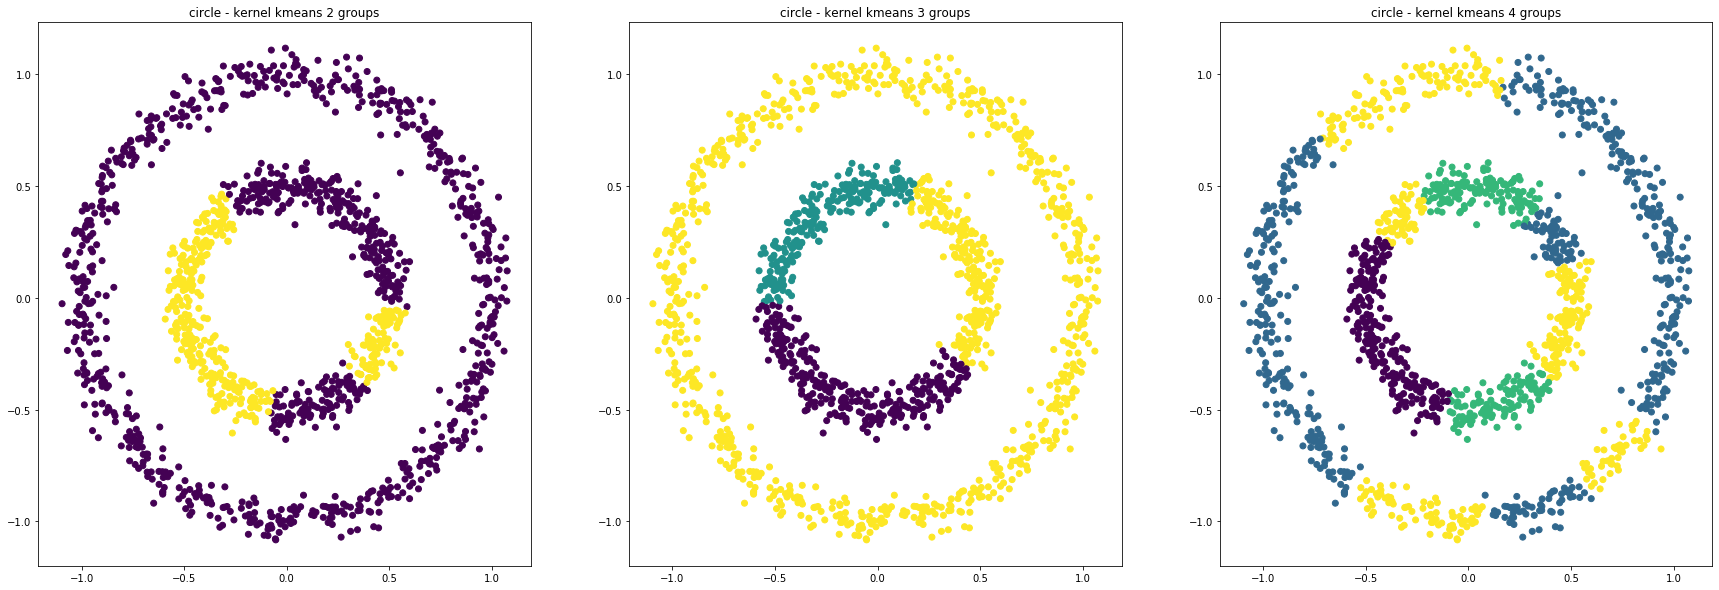

In [13]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(30, 10))

for i, ax in enumerate(axes):
    ngroups = i + 2
    group_indices = kernel_kmeans(circle, ngroups, 30, 1., 'circle - kernel kmeans {} groups'.format(ngroups), 'circle_kernel_kmeans_{}groups.gif'.format(ngroups))
    plot_result(ax, circle, None, group_indices, 'circle - kernel kmeans {} groups'.format(ngroups))

plt.show()

### Moon - Random Init - 2, 3, 4 groups

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


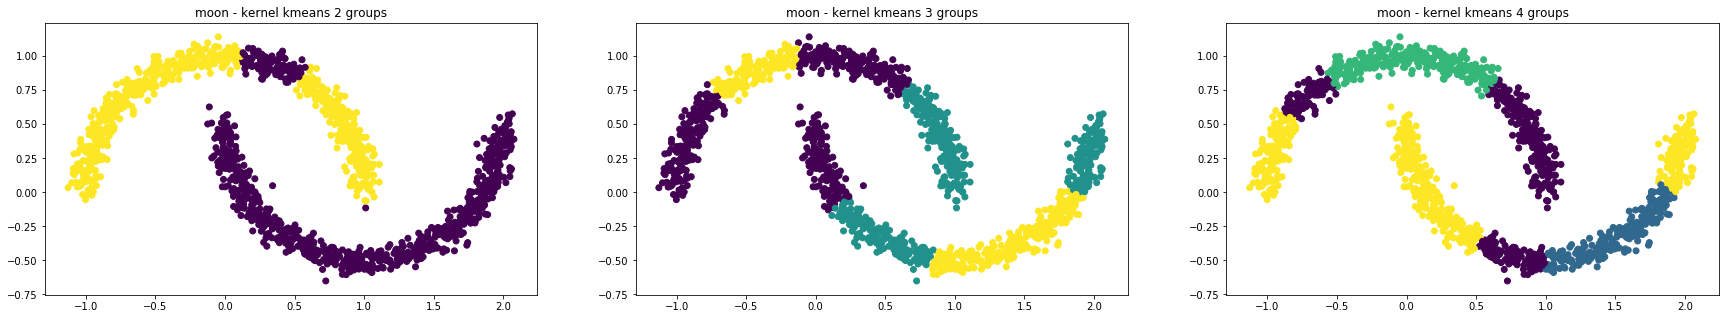

In [14]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(30, 5))

for i, ax in enumerate(axes):
    ngroups = i + 2
    group_indices = kernel_kmeans(moon, ngroups, 10, 1., 'moon - kernel kmeans {} groups'.format(ngroups), 'moon_kernel_kmeans_{}groups.gif'.format(ngroups))
    plot_result(ax, moon, None, group_indices, 'moon - kernel kmeans {} groups'.format(ngroups))

plt.show()

## Spectral Clustering

The basic spectral clustering is constructed based on the following pseudo-code.  
![Luxburg(2007)](https://taweihuang.hpd.io/wp-content/uploads/2017/07/%E5%9C%96%E7%89%873.png)  

It includes 
* Computing similarity matrix (which is implemented by RBF kernel)
* Computing normalized Laplacian, take the first K eigenvectors  
* Use the traditional K-means algorithm to perform the final clustering after normalizing the eigenspace.

In [15]:
def spectral_clustering(points, ngroups, gamma, var, kmeans_plus=False, title_prefix='', gif_filename='spectral_clustering.gif'):
    def rbf_distance_matrix(X, gamma=gamma, var=var):
        # base on https://stackoverflow.com/questions/47271662/what-is-the-fastest-way-to-compute-an-rbf-kernel-in-python
        X_norm = np.sum(X ** 2, axis = -1)
        K = var * np.exp(-gamma * (X_norm[:,None] + X_norm[None,:] - 2 * np.dot(X, X.T)))
        return K
    
    def normalized_laplacian(distance_matrix): # base on wiki
        # calculate degree matrix D
        D = np.diag(distance_matrix.sum(axis=1))
        return D - distance_matrix
    
    distance_matrix = rbf_distance_matrix(points)
    Lsys = normalized_laplacian(distance_matrix)
    
    # get first ngroups eigenvectors as U
    eigenvalues, eigenvectors = np.linalg.eig(Lsys)
    U = eigenvectors[:, np.argsort((eigenvalues))[:ngroups]]
    
    # normalize U to get T
    T = np.zeros_like(U)
    for i in range(points.shape[0]):
        T[i, :] = U[i, :] / np.sqrt((U[i, :] * U[i, :]).sum())
        
    # use kmeans to solve it
    return lloyd_kmeans(T, ngroups, kmeans_plus=kmeans_plus, title_prefix=title_prefix, gif_filename=gif_filename, gif_points_overwrite=points, verbose=True)[1], T

The performance is considerably better than kernel K-means'.  
Since it utilizes the connectivity of the data in feature space, it's able to tell the inner apart from the outer circle quite easily.
And if we examine the data in eigenspace, it's quite obvious that different groups, in the final output, do separate from each other.  
**In conclusion, the spectral clustering algorithm outperforms the 3 mentioned methods.**

One thing needs to be considered is that although the data in eigenspace might seem to intersect with other groups when `ngroup = 3 or 4`, they don't. It's simply because high dimensional data is not plottable without performing any projection.

### Circle - Random Init - 2, 3, 4 groups

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
/home/toosyou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/toosyou/.local/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


empty group found! retry!


/home/toosyou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/toosyou/.local/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


empty group found! retry!
empty group found! retry!


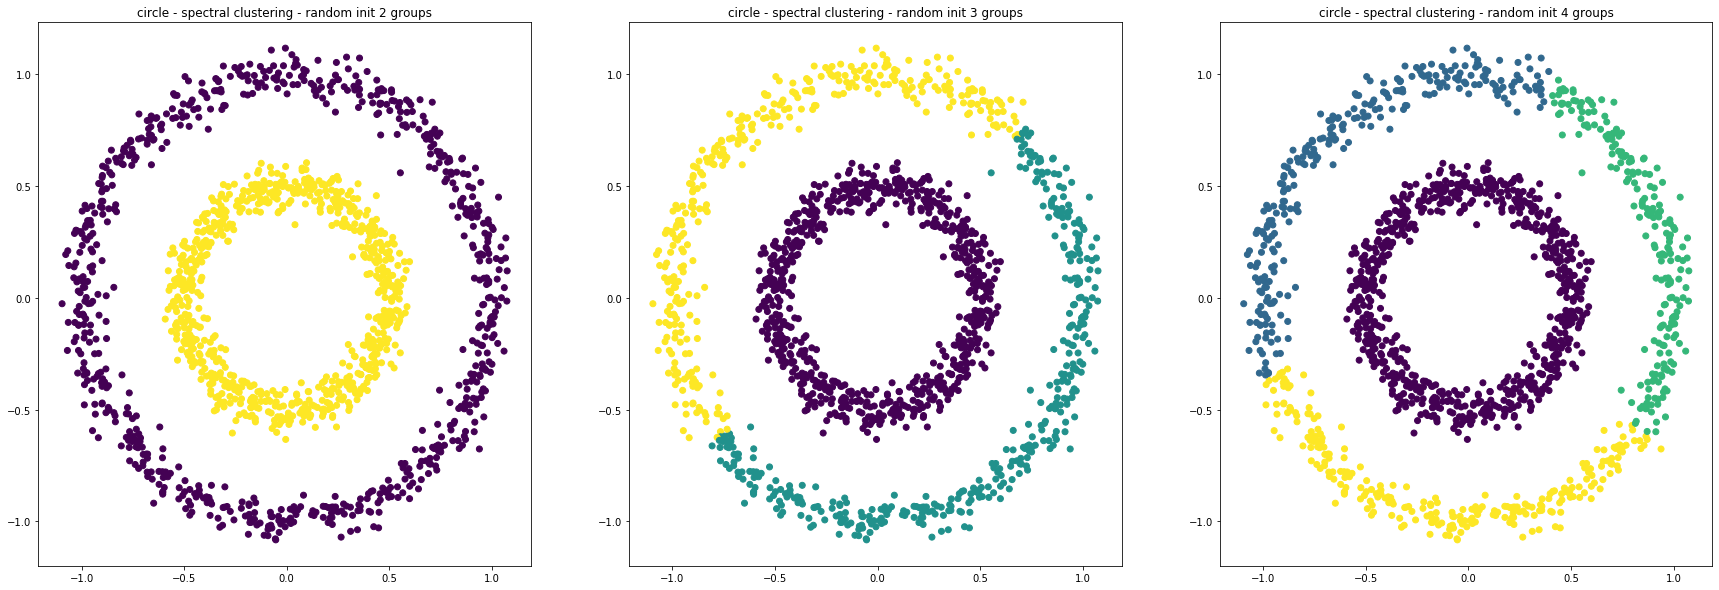

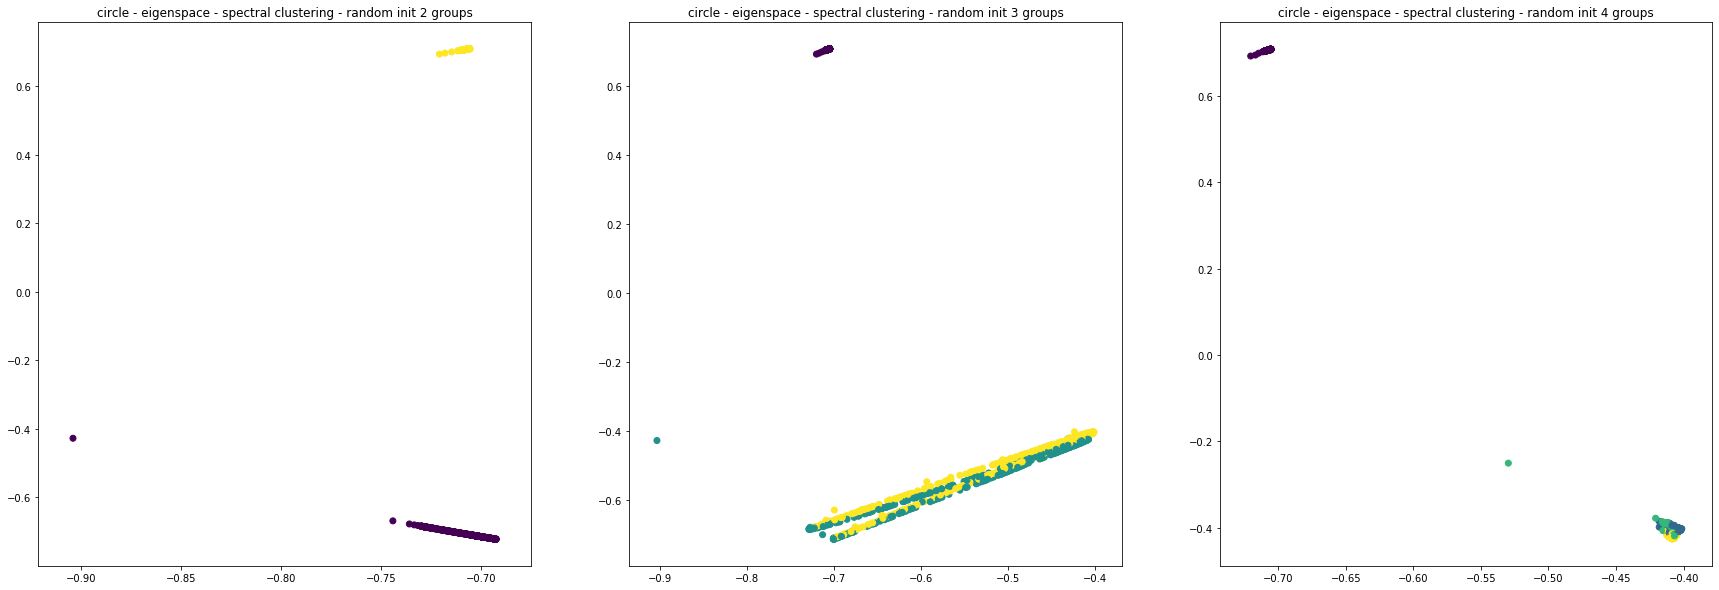

In [16]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(30, 10))
fig, eigen_axes = plt.subplots(1, 3, sharey=False, figsize=(30, 10))

for i, (ax, eax) in enumerate(zip(axes, eigen_axes)):
    ngroups = i + 2
    group_indices, T = spectral_clustering(circle, ngroups, 50., 1., False, 'circle - spectral clustering - random init {} groups'.format(ngroups), 'circle_spectral_clustering_random_init_{}groups.gif'.format(ngroups))
    plot_result(ax, circle, None, group_indices, 'circle - spectral clustering - random init {} groups'.format(ngroups))
    plot_result(eax, T, None, group_indices, 'circle - eigenspace - spectral clustering - random init {} groups'.format(ngroups))

plt.show()

### Circle - kmeans++ init - 2, 3, 4 groups

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


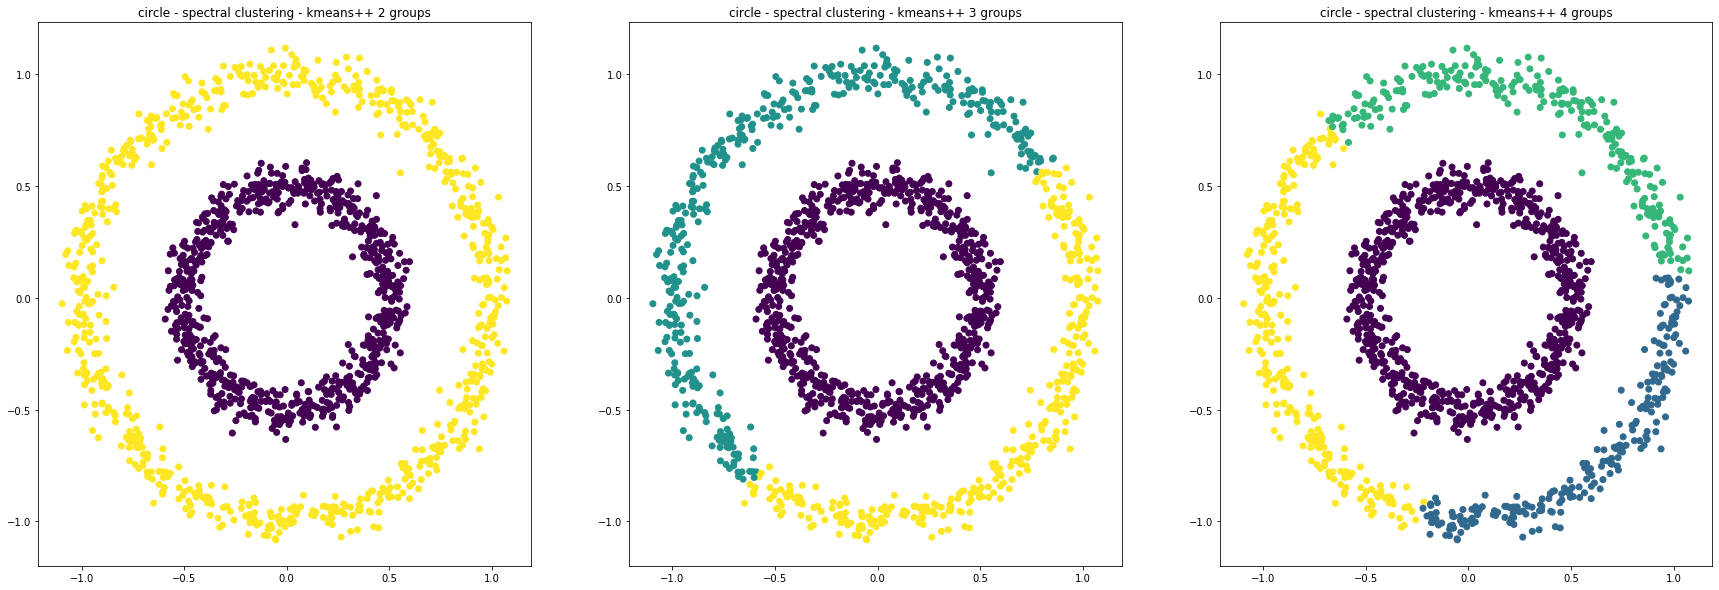

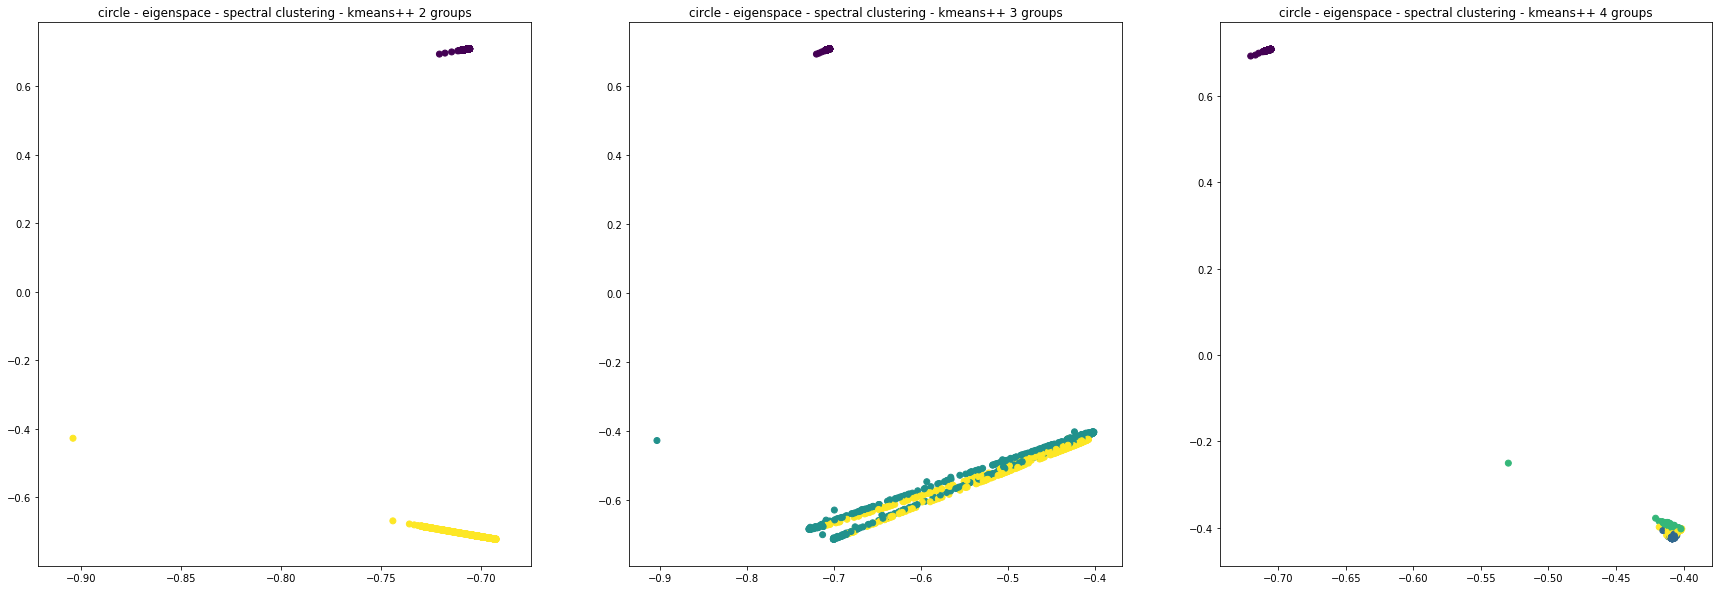

In [17]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(30, 10))
fig, eigen_axes = plt.subplots(1, 3, sharey=False, figsize=(30, 10))

for i, (ax, eax) in enumerate(zip(axes, eigen_axes)):
    ngroups = i + 2
    group_indices, T = spectral_clustering(circle, ngroups, 50., 1., True, 'circle - spectral clustering - kmeans++ {} groups'.format(ngroups), 'circle_spectral_clustering_keams++_{}groups.gif'.format(ngroups))
    plot_result(ax, circle, None, group_indices, 'circle - spectral clustering - kmeans++ {} groups'.format(ngroups))
    plot_result(eax, T, None, group_indices, 'circle - eigenspace - spectral clustering - kmeans++ {} groups'.format(ngroups))

plt.show()

### Moon - Random Init - 2, 3, 4 groups

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


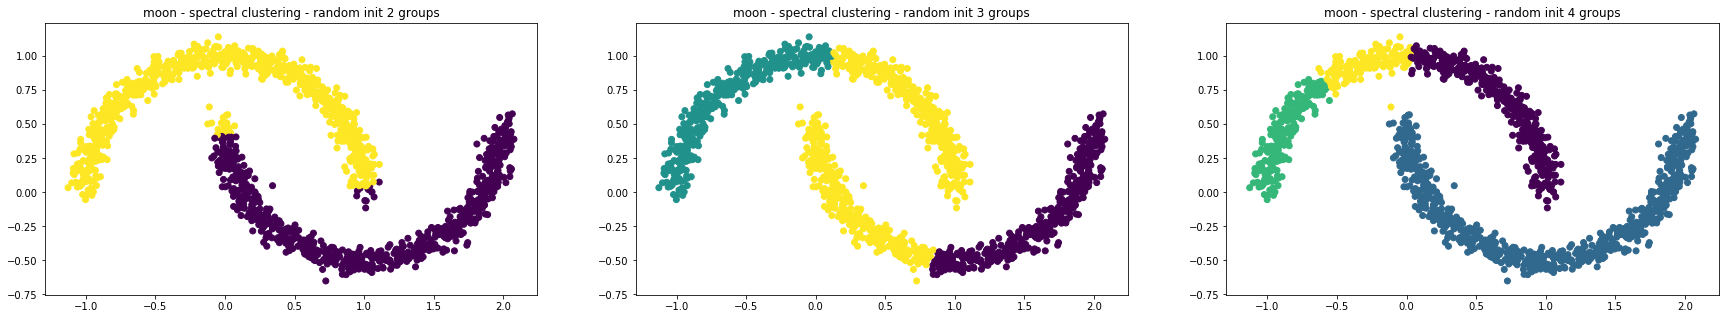

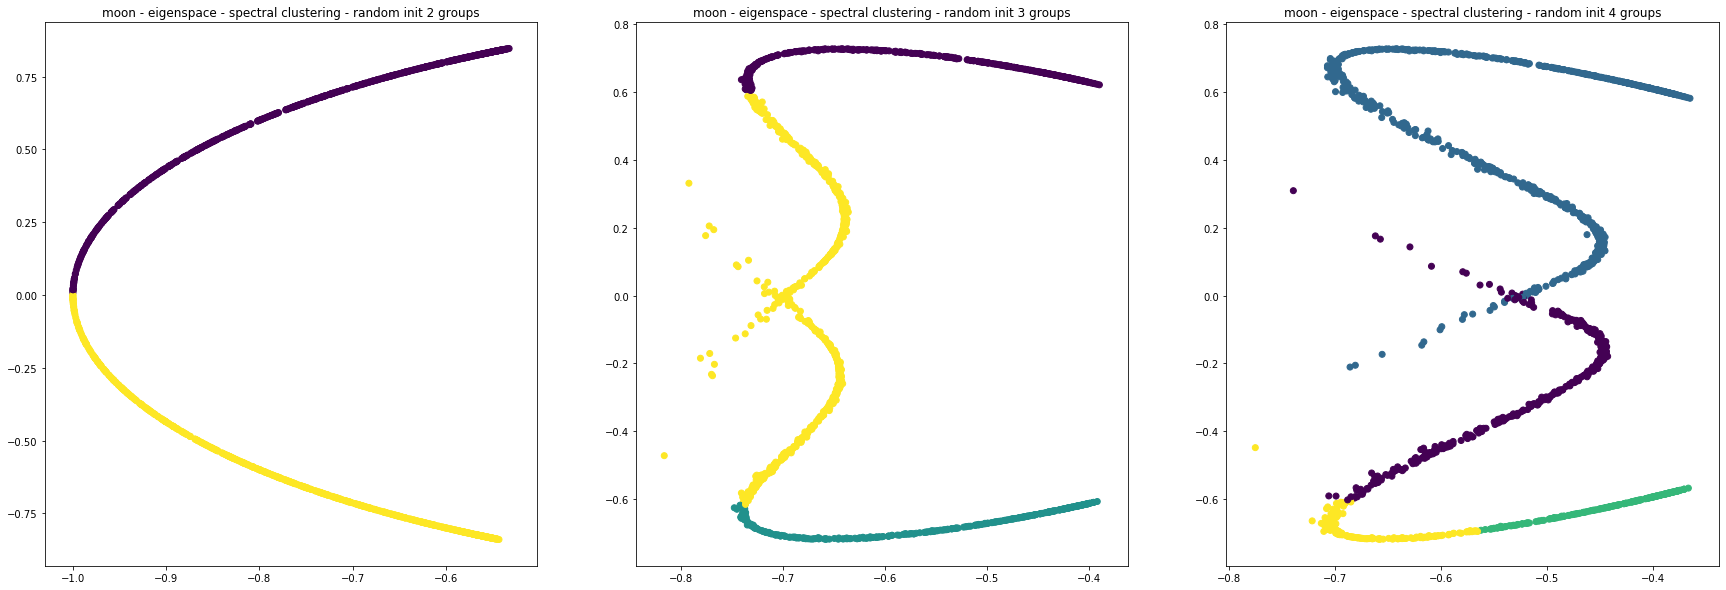

In [18]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(30, 5))
fig, eigen_axes = plt.subplots(1, 3, sharey=False, figsize=(30, 10))

for i, (ax, eax) in enumerate(zip(axes, eigen_axes)):
    ngroups = i + 2
    group_indices, T = spectral_clustering(moon, ngroups, 10., 1., False, 'moon - spectral clustering - random init {} groups'.format(ngroups), 'moon_spectral_clustering_random_init_{}groups.gif'.format(ngroups))
    plot_result(ax, moon, None, group_indices, 'moon - spectral clustering - random init {} groups'.format(ngroups))
    plot_result(eax, T, None, group_indices, 'moon - eigenspace - spectral clustering - random init {} groups'.format(ngroups))

plt.show()

### Moon - kmeans++ init - 2, 3, 4 groups

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


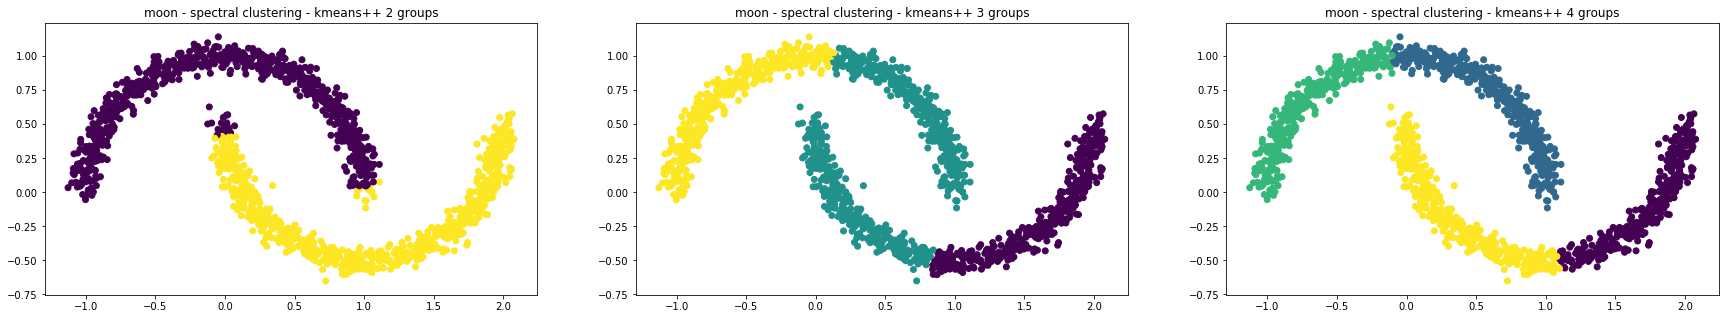

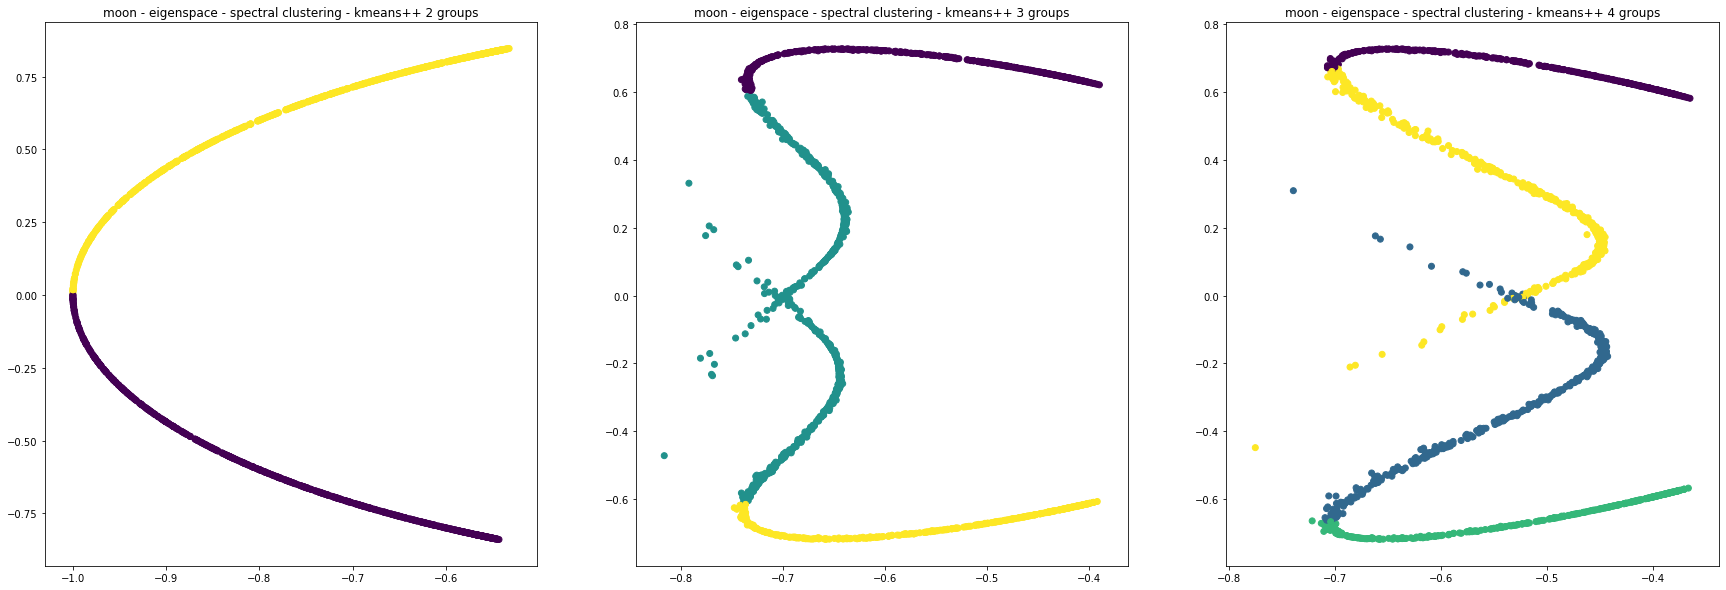

In [19]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(30, 5))
fig, eigen_axes = plt.subplots(1, 3, sharey=False, figsize=(30, 10))

for i, (ax, eax) in enumerate(zip(axes, eigen_axes)):
    ngroups = i + 2
    group_indices, T = spectral_clustering(moon, ngroups, 10., 1., True, 'moon - spectral clustering - kmeans++ {} groups'.format(ngroups), 'moon_spectral_clustering_kmeans++_{}groups.gif'.format(ngroups))
    plot_result(ax, moon, None, group_indices, 'moon - spectral clustering - kmeans++ {} groups'.format(ngroups))
    plot_result(eax, T, None, group_indices, 'moon - eigenspace - spectral clustering - kmeans++ {} groups'.format(ngroups))

plt.show()

## DBSCAN

The DBSCAN implementation below follows the pseudo-code in Wikipeidia. 
```
DBSCAN(D, eps, MinPts) {
   C = 0
   for each point P in dataset D {
      if P is visited
         continue next point
      mark P as visited
      NeighborPts = regionQuery(P, eps)
      if sizeof(NeighborPts) < MinPts
         mark P as NOISE
      else {
         C = next cluster
         expandCluster(P, NeighborPts, C, eps, MinPts)
      }
   }
}

expandCluster(P, NeighborPts, C, eps, MinPts) {
   add P to cluster C
   for each point P' in NeighborPts { 
      if P' is not visited {
         mark P' as visited
         NeighborPts' = regionQuery(P', eps)
         if sizeof(NeighborPts') >= MinPts
            NeighborPts = NeighborPts joined with NeighborPts'
      }
      if P' is not yet member of any cluster
         add P' to cluster C
   }
}

regionQuery(P, eps)
   return all points within P's eps-neighborhood (including P)
```

It's based on growing a cluster by the nearby points which exceed a certain density threshold so it doesn't rely on the `ngroups` parameter given by users.  
And it has a cluster which is labeled as noise, that doesn't associate with other groups enough, so DBSCAN might be more robust in some sense.

In [20]:
def dbscan(points, minimum_points, epsilon, title_prefix='', gif_filename='dbscan.gif'):
    def l2_distance_matrix(X):
        X_norm = np.sum(X ** 2, axis = -1)
        return np.sqrt(np.abs(X_norm[:,None] + X_norm[None,:] - 2 * np.dot(X, X.T)))
    
    def epsilon_neighbors(index_point, distance_matrix):
        return np.where(distance_matrix[index_point, :] < epsilon)[0]
    
    def cluster_to_group_indices(clusters):
        group_indices = -np.ones((points.shape[0], ))
        for index_cluster, cluster in enumerate(clusters):
            group_indices[cluster] = index_cluster
        return group_indices
    
    gif_generator = GIFGenerator(np.append(points, np.array([[-1, 1]]*2), axis=0), title_prefix, color_fix=True)
    gif_generator.add_frame(group_indices= np.append(-np.ones((points.shape[0], )), np.arange(0, 2, 1)))
    
    # basically from https://zh.wikipedia.org/wiki/DBSCAN
    clusters = list()
    distance_matrix = l2_distance_matrix(points)
    point_processed = np.zeros((points.shape[0], ), dtype=bool) # all False
    point_clustered = np.zeros((points.shape[0], ), dtype=bool) # all False
    for index_point in range(points.shape[0]):
        if point_processed[index_point]:
            continue
        point_processed[index_point] = True
        
        index_epsilon_neighbors = epsilon_neighbors(index_point, distance_matrix)
        if index_epsilon_neighbors.shape[0] < minimum_points:
            pass # mark as noise
        else:
            tmp_cluster = list()
            last_length = 0
            point_clustered[index_point] = True
            tmp_cluster.append(index_point)
            
            while index_epsilon_neighbors.shape[0] > 0:
                # pop the last element
                pi = index_epsilon_neighbors[-1]
                index_epsilon_neighbors = index_epsilon_neighbors[:-1]
                
                if not point_processed[pi]:
                    point_processed[pi] = True
                    ien = epsilon_neighbors(pi, distance_matrix)
                    if ien.shape[0] >= minimum_points:
                        index_epsilon_neighbors = np.append(index_epsilon_neighbors, ien, axis=0)
                        
                if not point_clustered[pi]:
                    point_clustered[pi] = True
                    tmp_cluster.append(pi)
                    
                    if len(tmp_cluster) - last_length > 20:
                        last_length = len(tmp_cluster)
                        tmp_tmp_clusters = copy.deepcopy(clusters)
                        tmp_tmp_clusters.append(tmp_cluster)
                        gif_generator.add_frame(group_indices=np.append(cluster_to_group_indices(tmp_tmp_clusters), np.arange(0, 2, 1), axis=0))
                    
            clusters.append(tmp_cluster)
            
    gif_generator.save(gif_filename, interval=100)
    return cluster_to_group_indices(clusters)

### Circle

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


Text(0.5, 1.0, 'circle - DBSCAN')

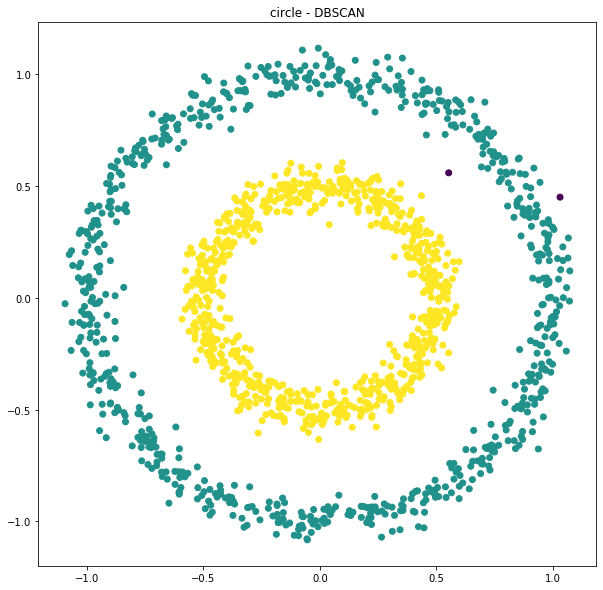

In [21]:
plt.figure(figsize=(10, 10))
plt.scatter(circle[:, 0], circle[:, 1], c=dbscan(circle, 2, 0.1, 'circle - DBSCAN', 'circle_DBSCAN.gif'))
plt.title('circle - DBSCAN')

### Moon

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


Text(0.5, 1.0, 'moon - DBSCAN')

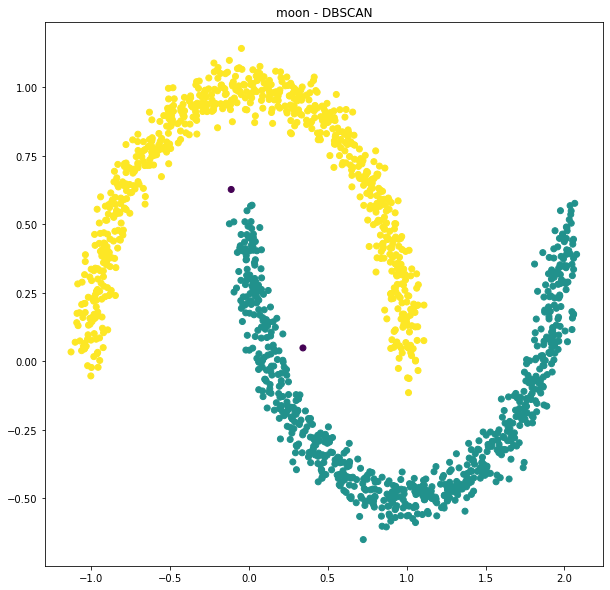

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(moon[:, 0], moon[:, 1], c=dbscan(moon, 2, 0.1, 'moon - DBSCAN', 'moon_DBSCAN.gif'))
plt.title('moon - DBSCAN')